In [1]:
## Imports

import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[1])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from sigpy import mri
import scipy
import pickle
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import seaborn as sns
import sigpy as sp
import cupy as cp
import numpy as np
from sigpy.mri.app import TotalVariationRecon, L1WaveletRecon
from scipy.io import savemat
import twixtools
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.signal import butter,filtfilt


## My files
from ksp_plot_helpers import plot_ksp_data_multichannel, find_and_plot_acquired_region
from raw_data_utils import get_kspace_data, get_TR
from resp_signal_functions import resp_signal_all_slices, resp_signal_single_slice, resp_signal_center_sample_single_slice
from resp_signal_plot_functions import *
import gating_functions
from pca_helper import pca_resp_signal

## Data loading

Software version: VD/VE (!?)

Scan  0


100%|██████████| 15.9G/15.9G [00:13<00:00, 1.24GB/s]


Full number of partitions = 72
ksp_data.shape = (15, 58, 2002, 256)
Average value, slices vs samples per gate = 3.160565756843425e-05
Average value, readouts vs spokes per gate = 1.808665729186032e-05
Average value, slices vs center sample per gate = 8.472998160868883e-05


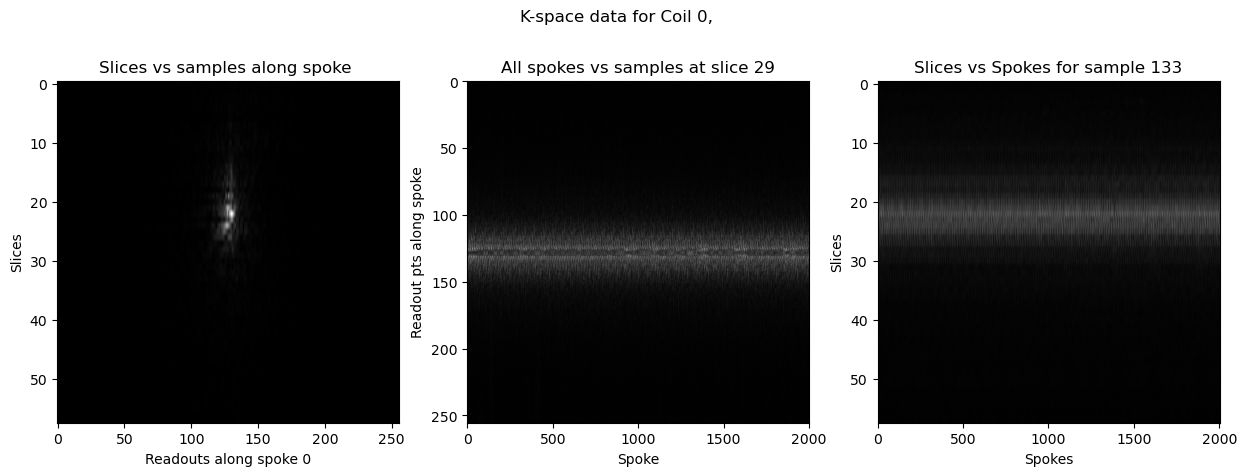

In [4]:
data_file_pt2 = '/data/lilianae/NaF_Patient2/anon_meas_MID00082_FID64646_Tho_fl3d_star_vibe_991_nav_tj_2000sp_AllCoils_SOS_2.dat'
# data_file_pt1 = '/data/lilianae/NaF_MtSinai/anon_meas_MID00118_FID60738_Tho_fl3d_star_vibe_991_nav_tj_2000sp_AllCoils_SOS.dat'

multi_twix, mapped, ksp_data = get_kspace_data(data_file_pt2)
fig, axs = plot_ksp_data_multichannel(ksp_data=ksp_data, coil_idx=0, center_sample=133)



In [3]:
print(data_0.shape)

(1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 58, 1, 1, 2002, 15, 352)


Average value, slices vs samples per gate = 3.160565756843425e-05
Average value, readouts vs spokes per gate = 3.451176598900929e-05
Average value, slices vs center sample per gate = 0.00014568846381735057


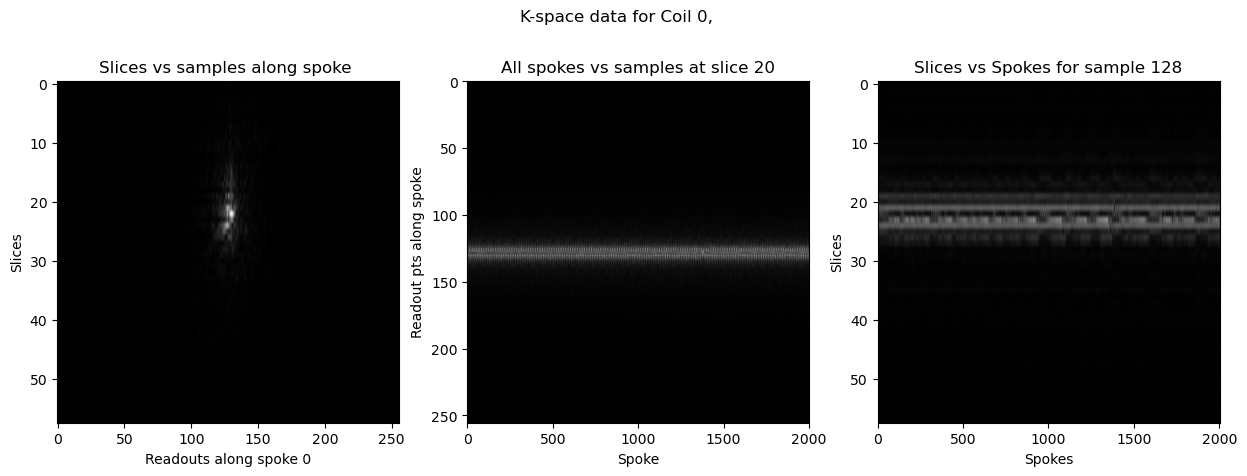

In [3]:
fig, axs = plot_ksp_data_multichannel(ksp_data=ksp_data, coil_idx=0, center_slice=20, center_sample=128)

Look at signal intensity distribution

Signal energy per slice: [1.38091258e-04 1.56621565e-04 1.80559247e-04 2.06059020e-04
 2.39168250e-04 2.66172574e-04 3.02645640e-04 3.41502484e-04
 3.99719545e-04 4.58145747e-04 5.49904304e-04 6.36885874e-04
 8.14653060e-04 1.04507722e-03 1.66944868e-03 2.35351594e-03
 3.00905597e-03 5.48646972e-03 6.97145378e-03 1.10711874e-02
 1.87381841e-02 3.20209339e-02 3.07932049e-02 2.79133786e-02
 1.84105728e-02 1.12677198e-02 5.41873462e-03 3.09068430e-03
 1.81405491e-03 1.34669733e-03 1.03728962e-03 8.22474714e-04
 6.73449307e-04 5.68430289e-04 4.74130444e-04 4.14975162e-04
 3.63388943e-04 2.93272780e-04 2.70598190e-04 2.53276026e-04
 2.28780322e-04 2.06886602e-04 1.99652975e-04 1.89748360e-04
 1.66835423e-04 1.60090582e-04 1.47342202e-04 1.39977928e-04
 1.31735724e-04 1.23189995e-04 1.13192233e-04 1.05263891e-04
 1.05189945e-04 9.63022176e-05 9.22549298e-05 8.69028736e-05
 8.22349102e-05 7.90926424e-05]
Threshold: 0.000320209339261055
Acquired region detected: slices 7 to 36
Width of center 

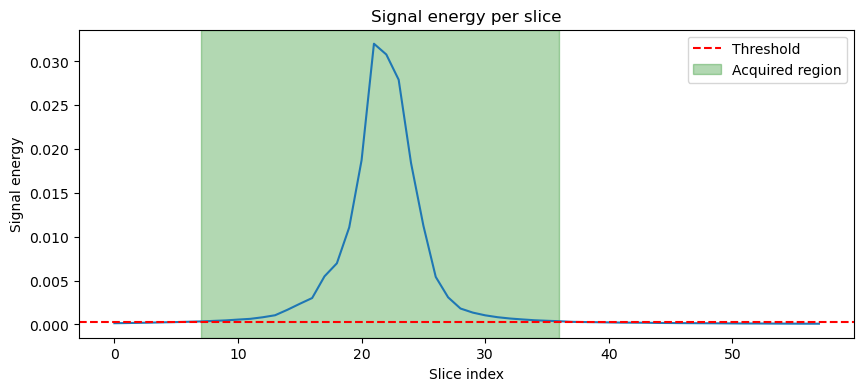

In [4]:
acquired_start, acquired_end = find_and_plot_acquired_region(ksp_data)

Extract TR from header

In [5]:
TR = get_TR(mapped)

TR from data: 0.006 sec


Play with start and end samples for signal generation

In [6]:
start_sample_idx = 123
end_sample_idx = 133

In [7]:
print(f"\nUse all slices for signal: ")
print("="*60)
raw_signal_all, filt_signal_all = resp_signal_all_slices(ksp_data, TR, cutoff_hz=[0.2, 0.33], 
                                                         start_sample_idx=start_sample_idx, 
                                                         end_sample_idx=end_sample_idx,
                                                         filter_type='bandpass')
print(f"\nUse center slice for signal: ")
print("="*60)
raw_signal_single_slice, filt_signal_single_slice, TR_effective1, fs_effective1 = resp_signal_single_slice(ksp_data, TR, cutoff=[0.2, 0.33],
                                                                                    center_slice=20, start_sample_idx=start_sample_idx, 
                                                                                    end_sample_idx=end_sample_idx, filter_type='bandpass')
print(f"\nUse center sample + center slice for signal: ")
print("="*60)
raw_signal_center_sample, filt_center_sample, TR_effective2, fs_effective2 = resp_signal_center_sample_single_slice(ksp_data, TR, cutoff=0.25,
                                                                                 center_slice=22)



Use all slices for signal: 
Sampling frequency (Hz): 166.667
full timescale goes to 696.69 seconds
filt_signal_all.shape: (15, 116116)
raw_signal_all.shape: (15, 116116)

Use center slice for signal: 

Using center slice: 20 out of 58 slices

Effective sampling frequency (Hz): 2.874

Original sampling frequency would have been: 166.667 Hz

Full timescale goes to 696.3 seconds

Time between respiratory samples: 0.348 seconds
filt_signal_all.shape: (15, 2002)
raw_signal_all.shape: (15, 2002)

Use center sample + center slice for signal: 

Using center slice: 22 out of 58 slices

Effective sampling frequency (Hz): 2.874

Original sampling frequency would have been: 166.667 Hz

Full timescale goes to 696.3 seconds

Time between respiratory samples: 0.348 seconds
filt_signal_all.shape: (15, 2002)
raw_signal_all.shape: (15, 2002)



From all slices for signal: 


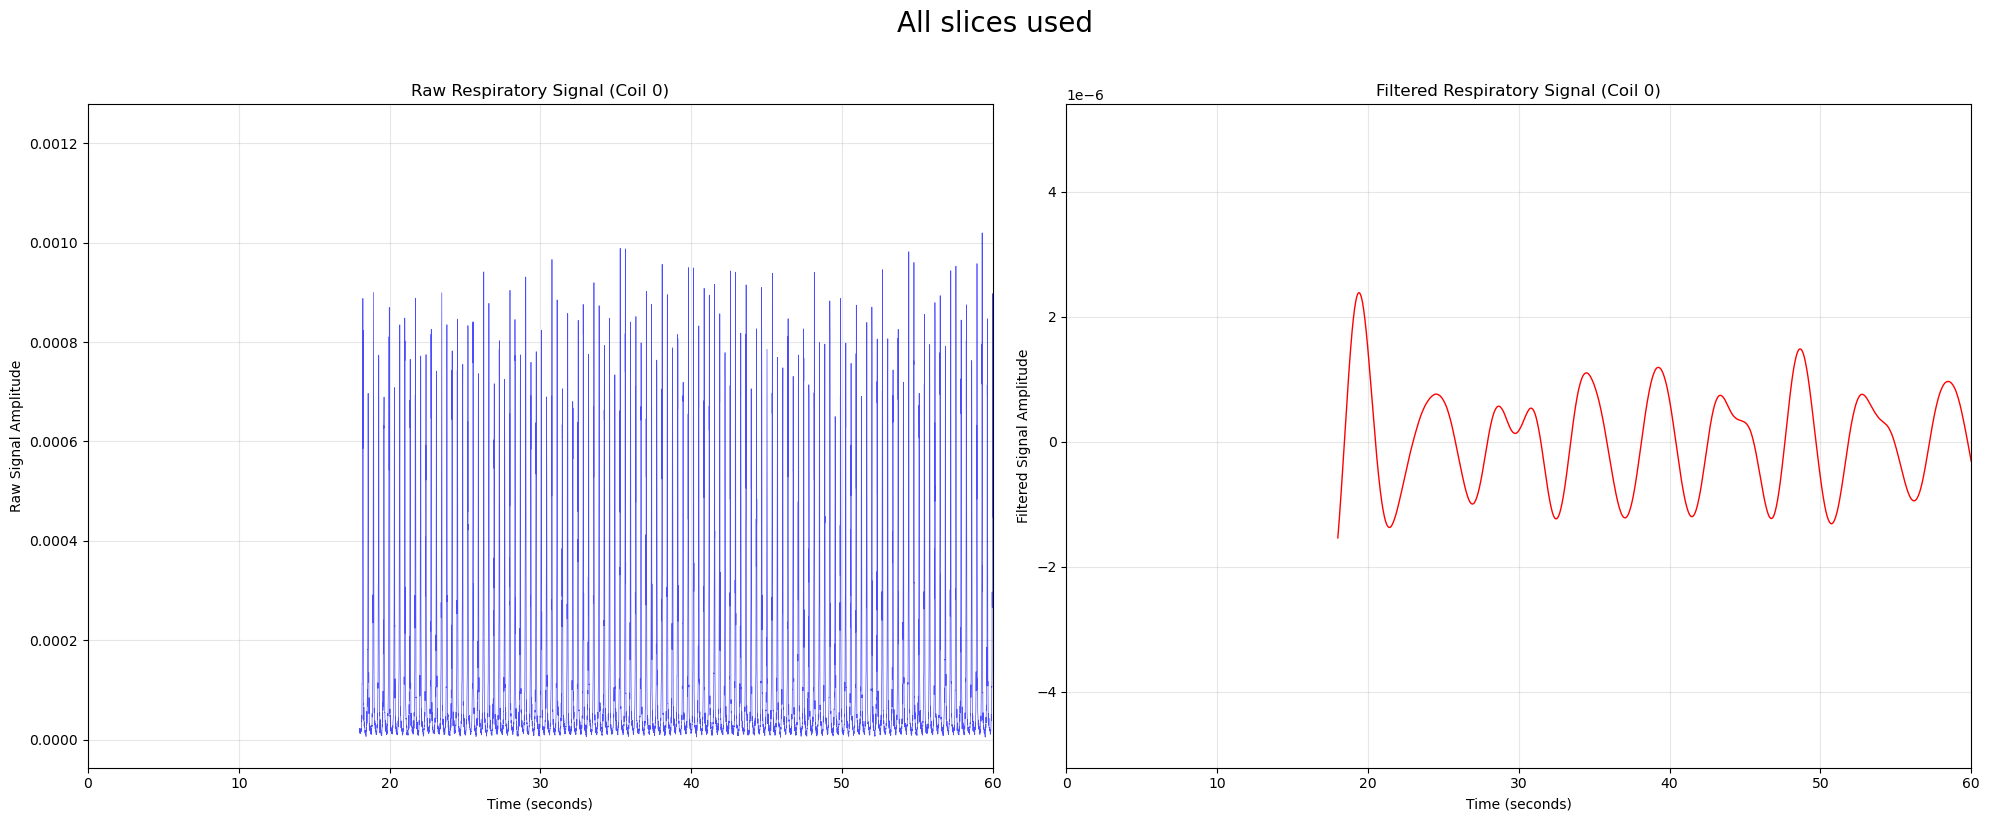

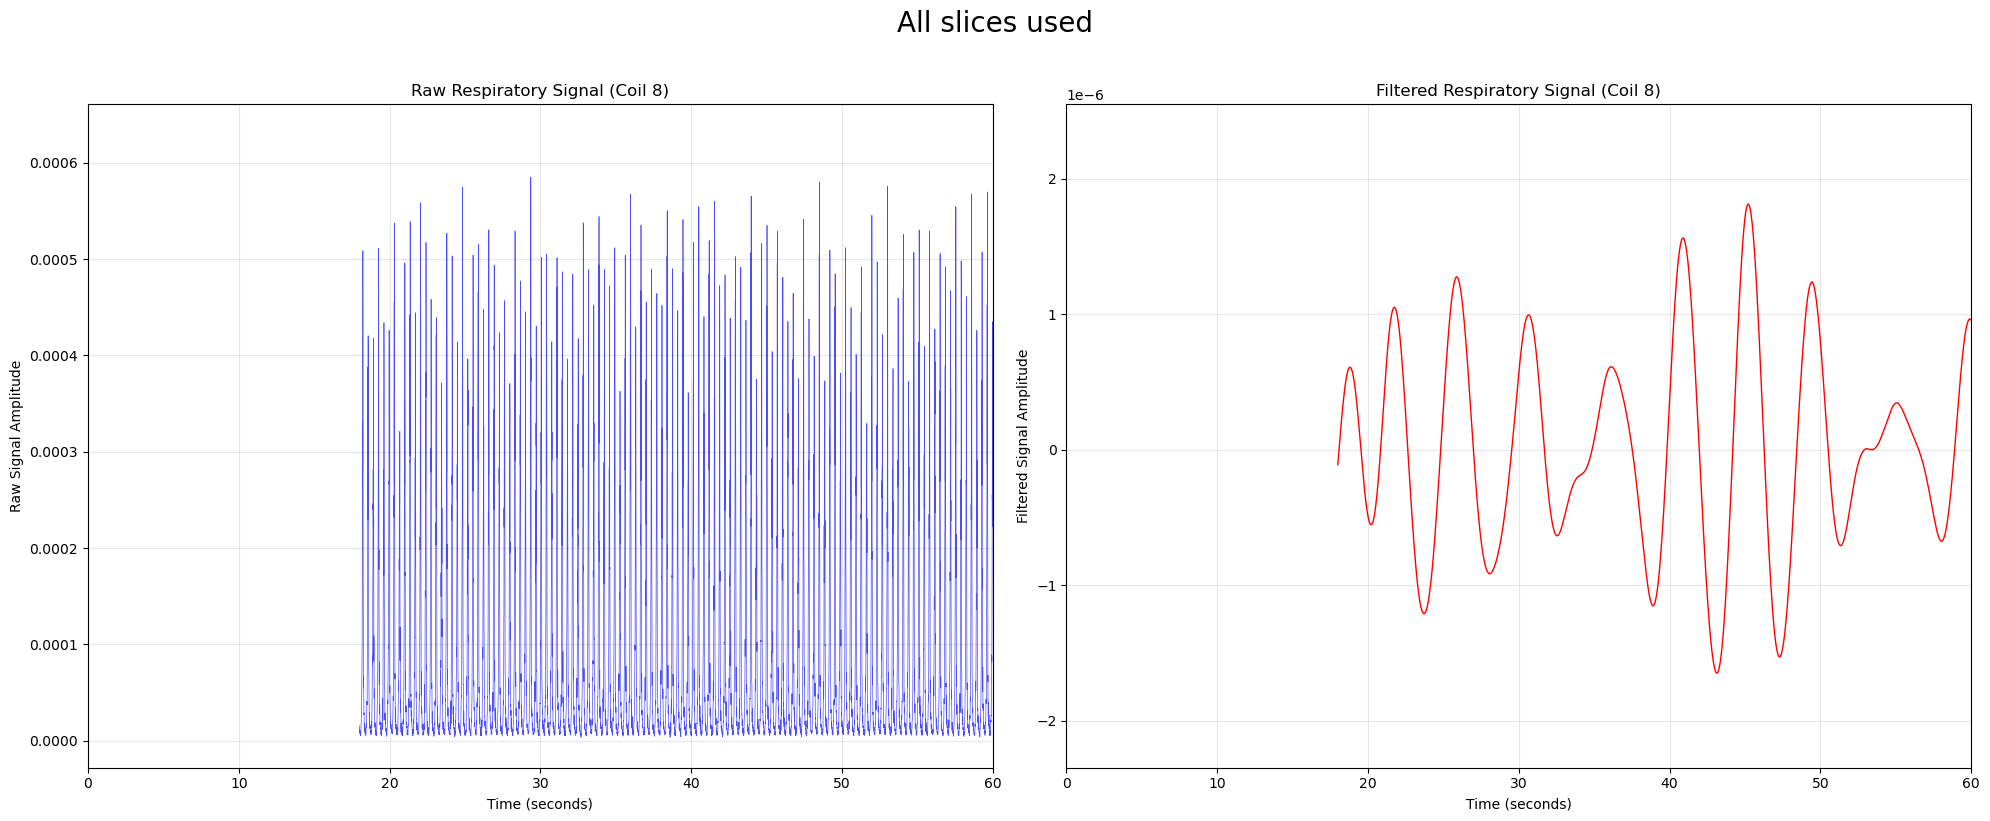

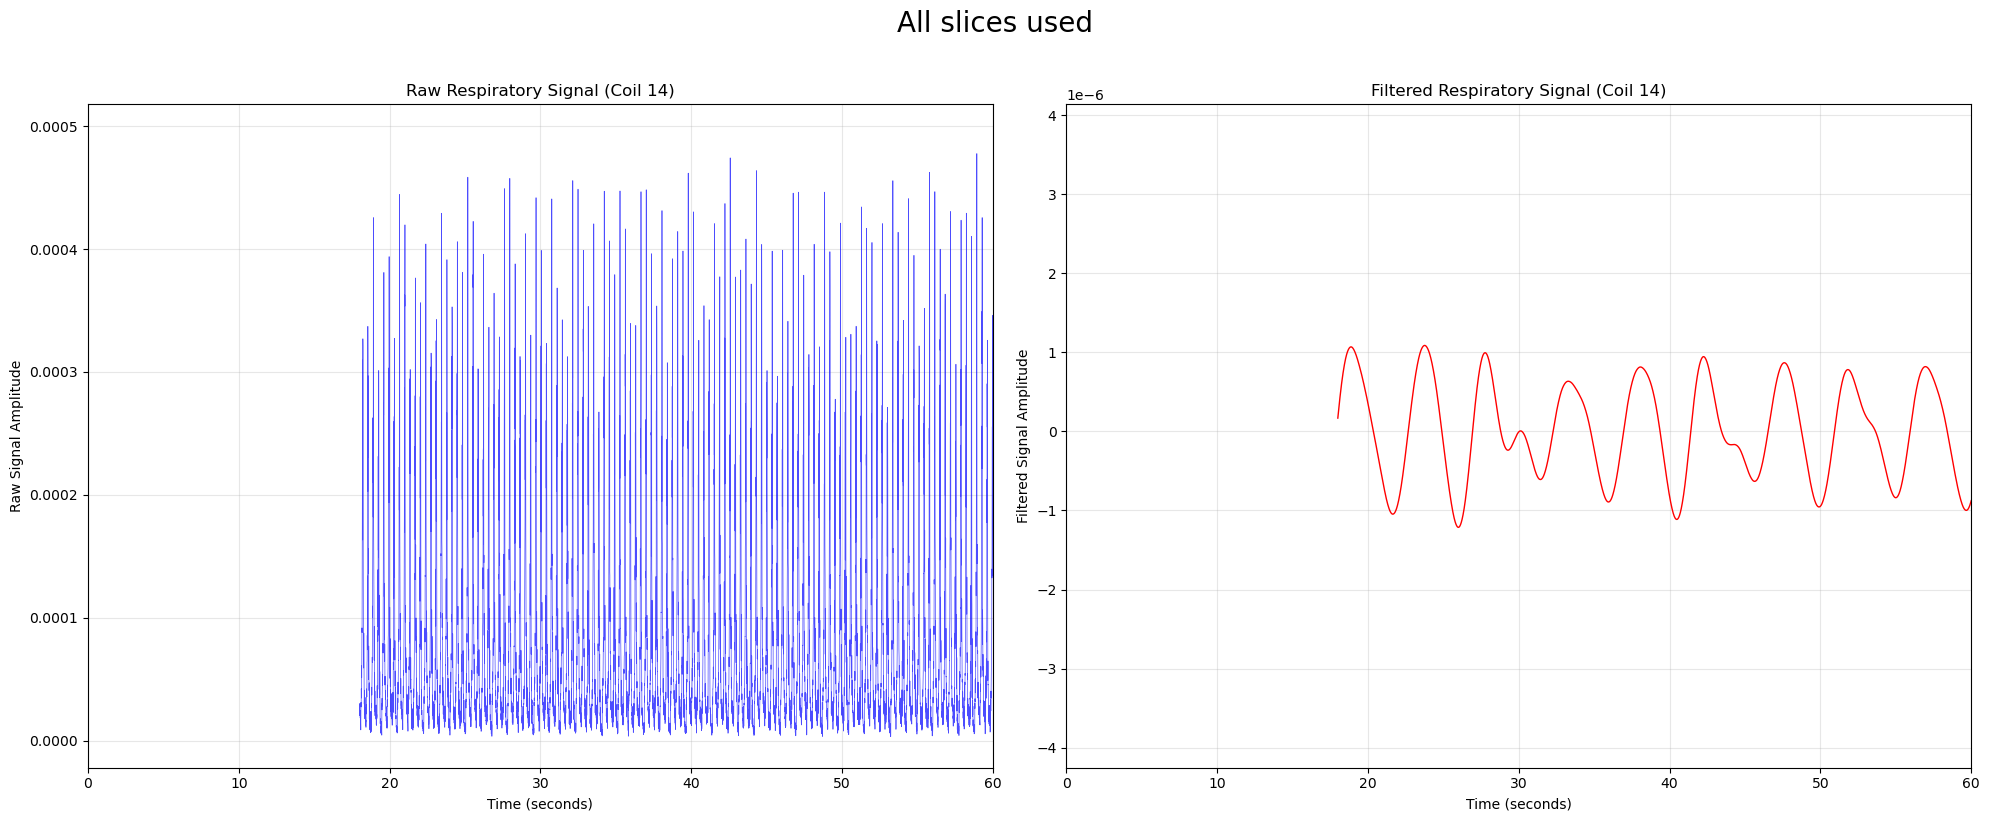


From center slice for signal: 


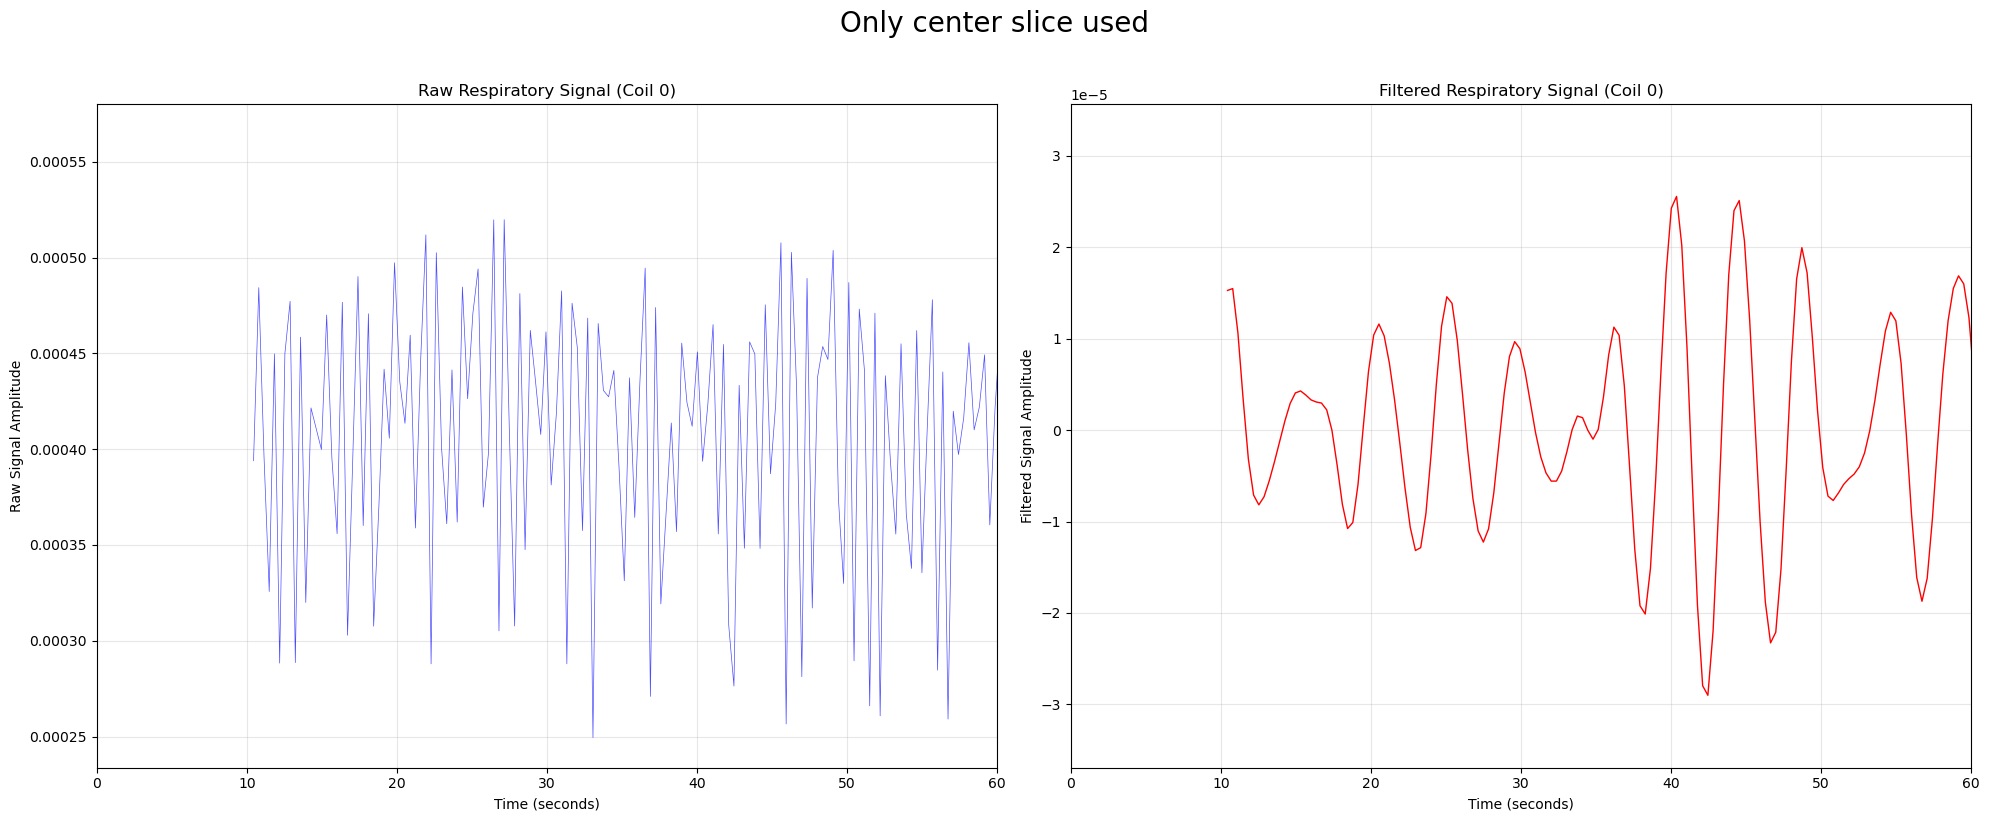

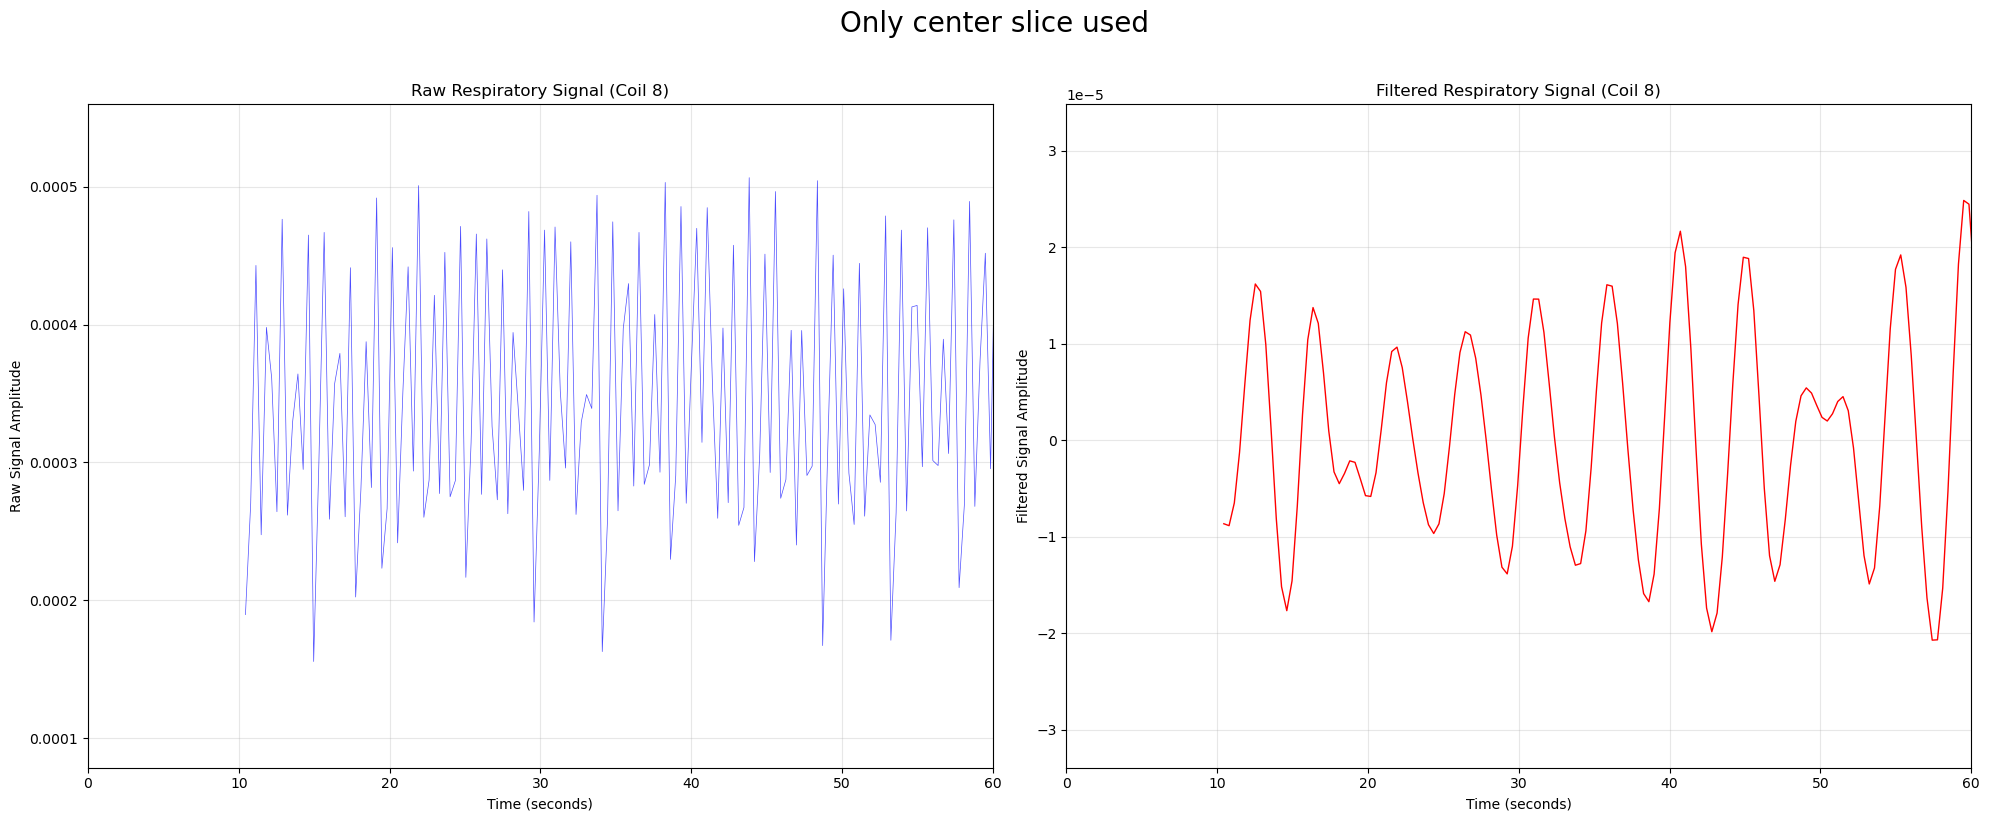

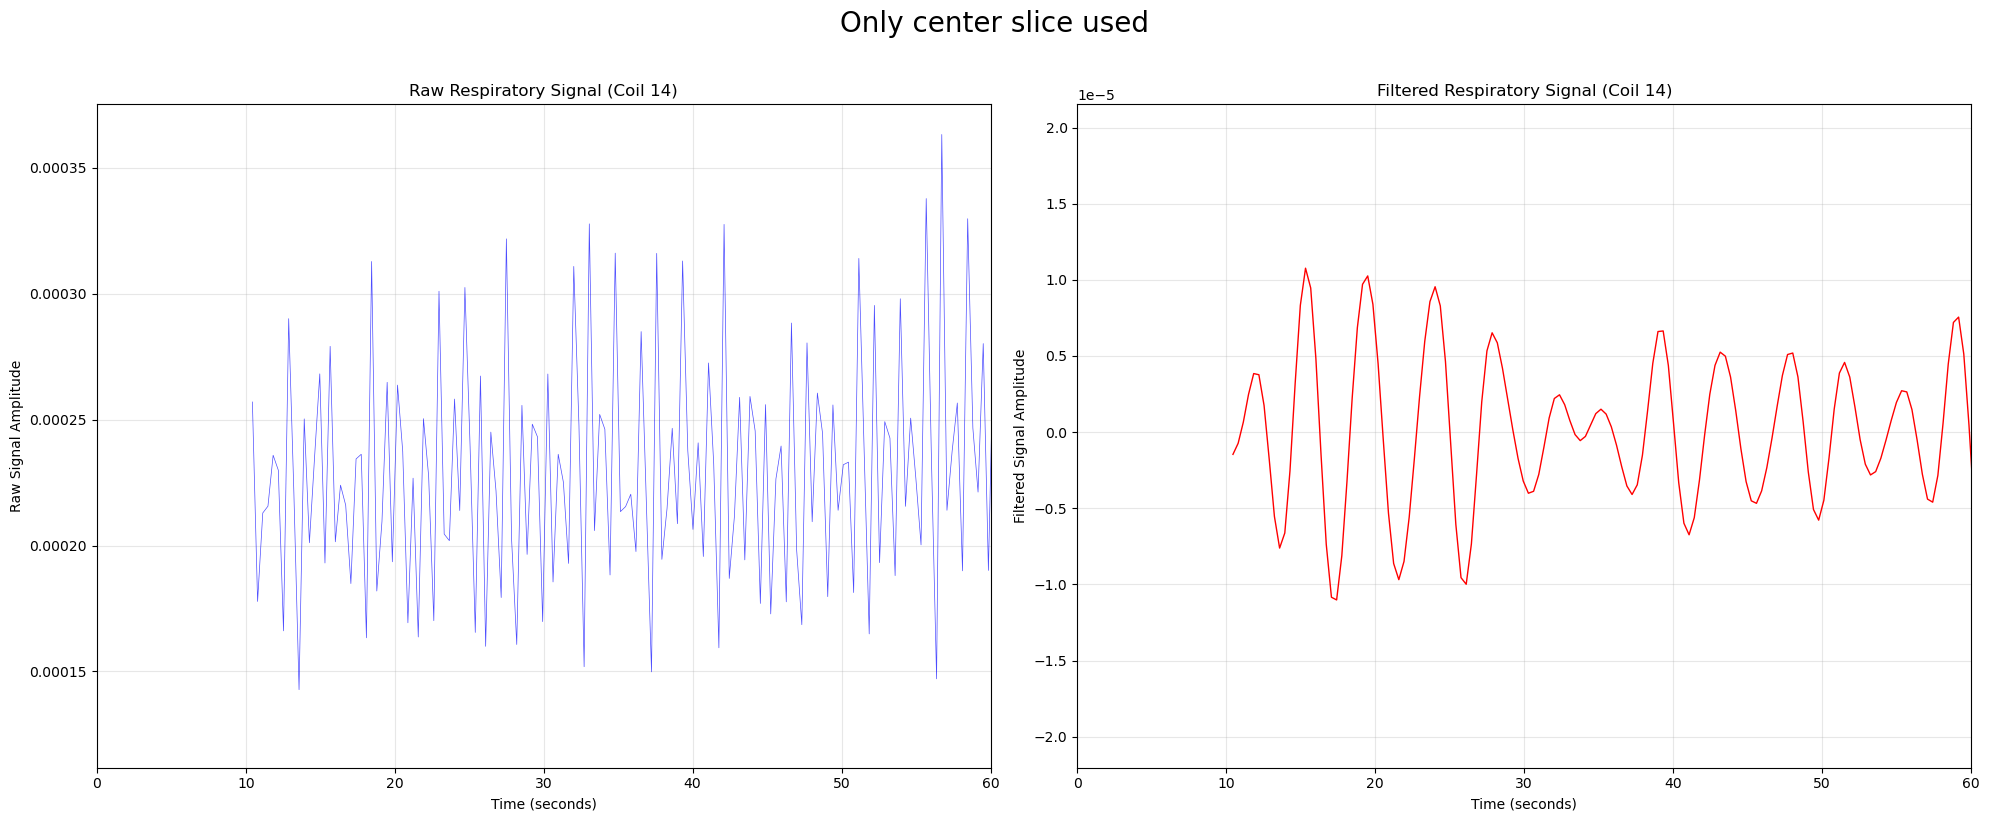

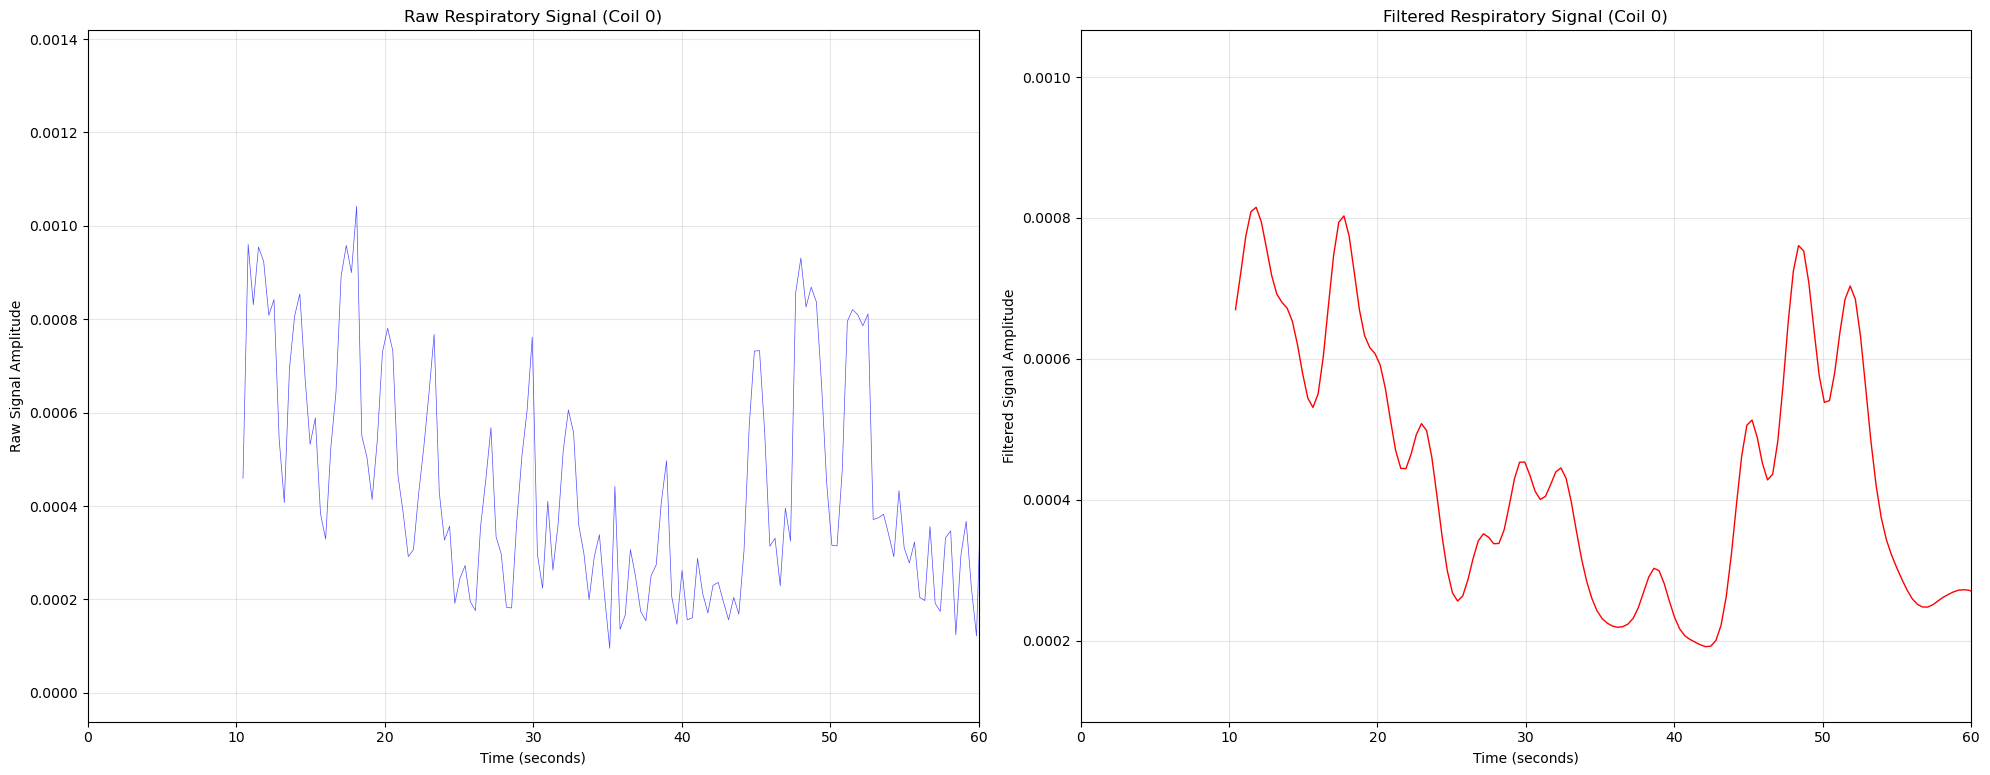

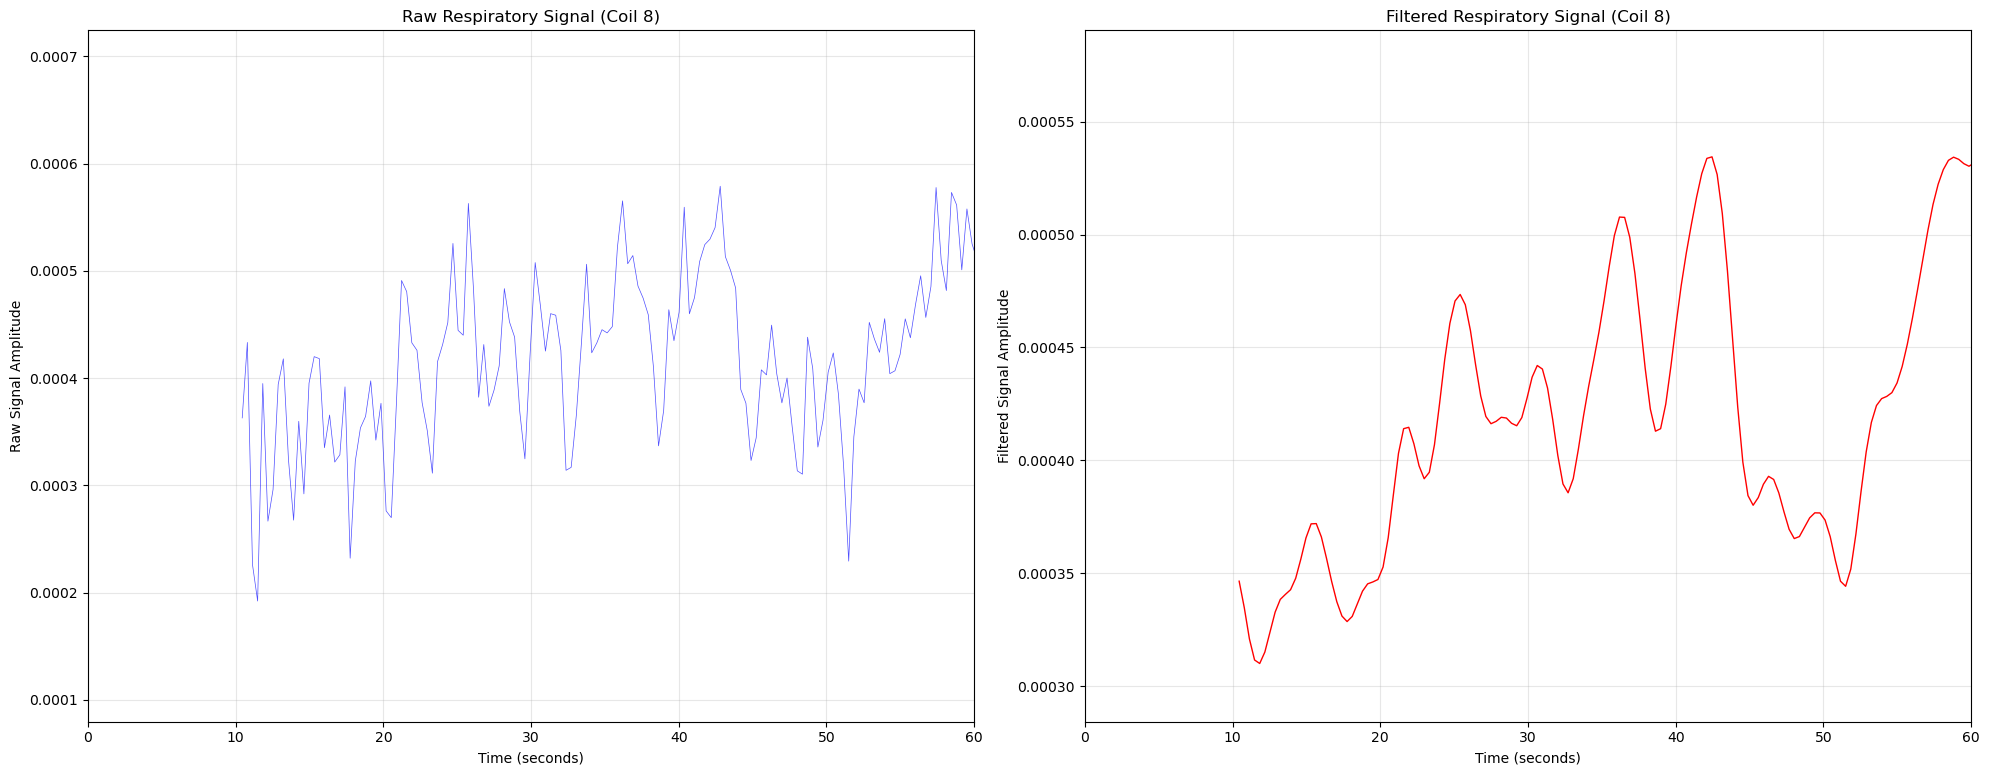

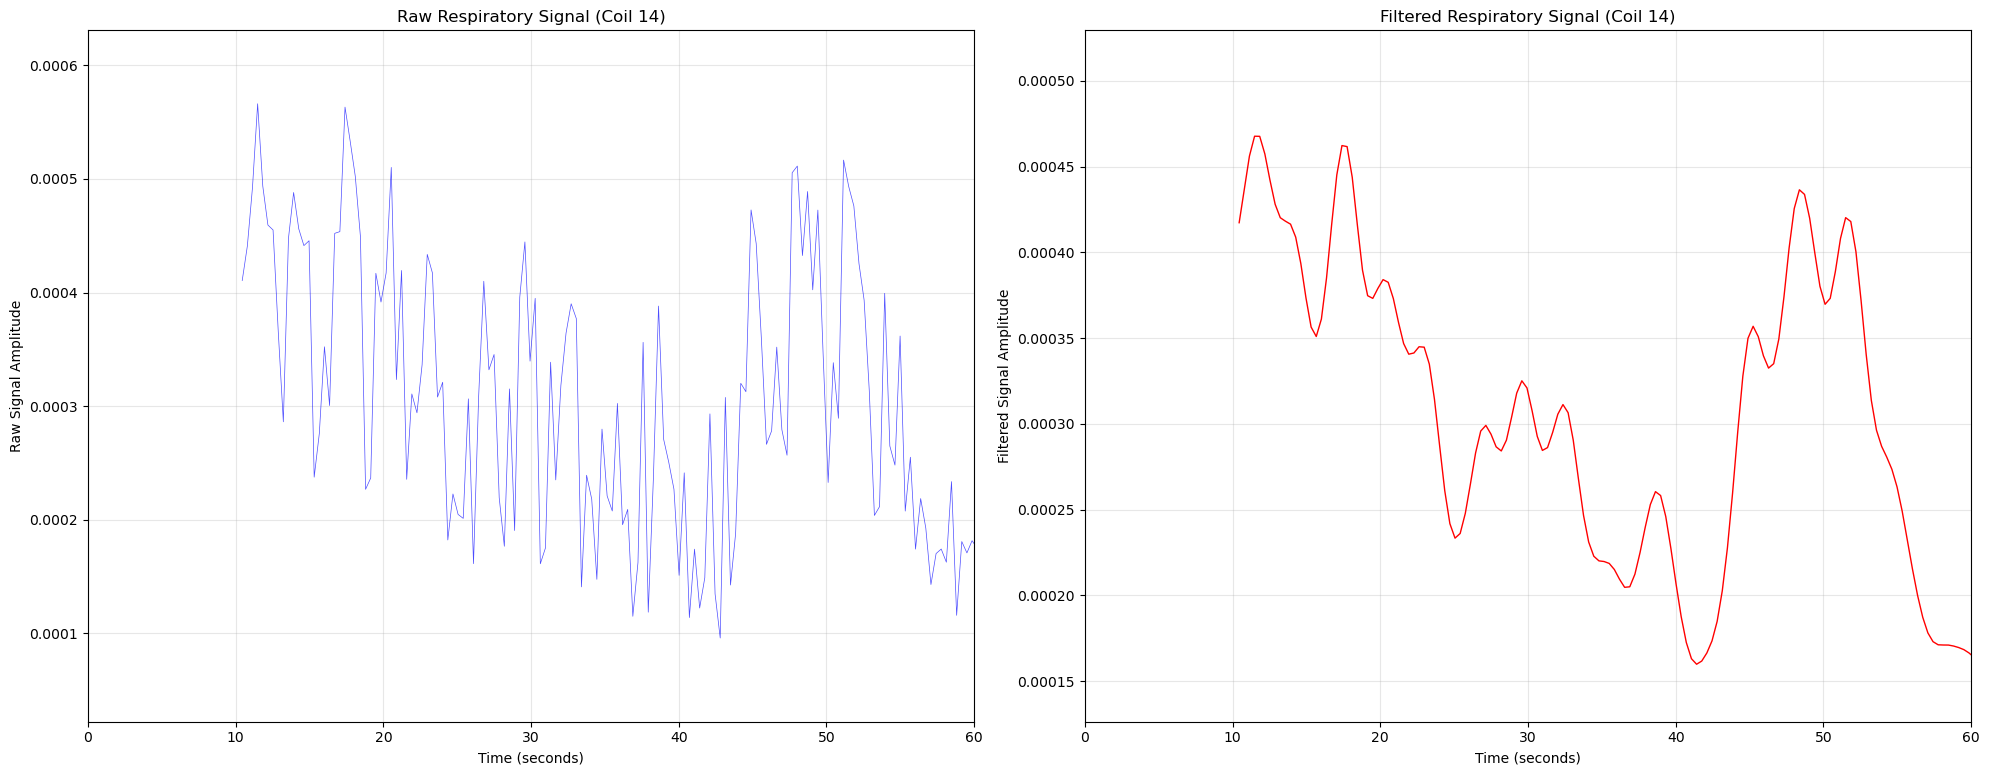

In [8]:
coil_indices = [0, 8, 14]
print(f"\nFrom all slices for signal: ")
print("="*60)
plot_raw_and_filtered_signal(raw_signal_all, filt_signal_all, coil_indices, TR, 
                             samples_to_discard=3000, title_info="All slices used")
print(f"\nFrom center slice for signal: ")
print("="*60)
plot_raw_and_filtered_signal(raw_signal_single_slice, filt_signal_single_slice, coil_indices, TR_effective1, 
                             samples_to_discard=30,title_info="Only center slice used")
plot_raw_and_filtered_signal(raw_signal_center_sample, filt_center_sample, coil_indices, TR_effective2, samples_to_discard=30)

### Try frequency spectrum analysis

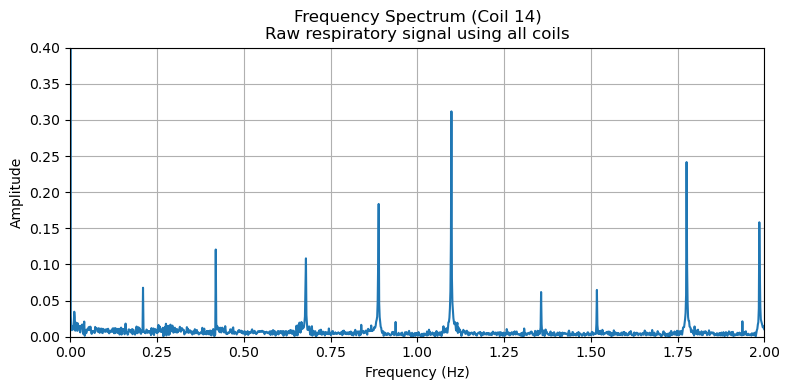

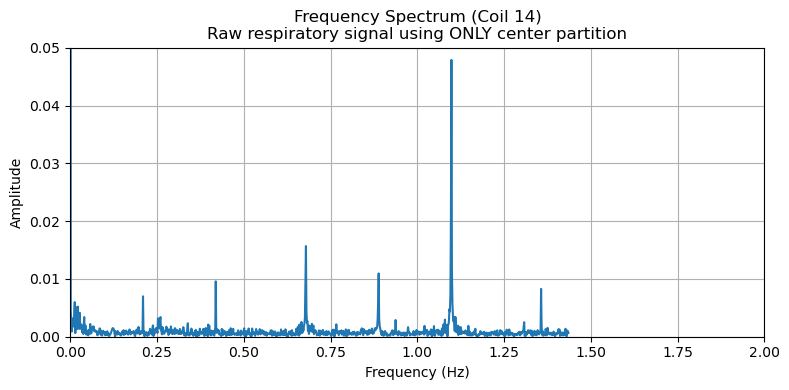

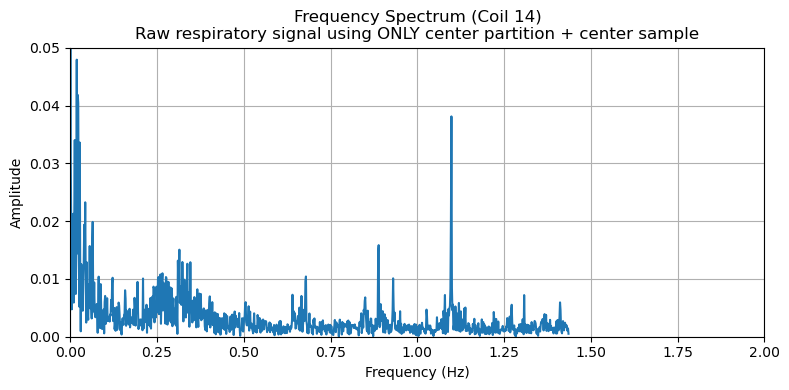

In [10]:
def plot_freq_spectrum(signal_coils, coil_idx, TR, fmax=2, amp_limit=None, title_info=""):
    """
    Plot the frequency spectrum (magnitude of FFT) for a given coil signal.

    Parameters
    ----------
    signal_coils : array-like
        Array of signals from different coils, shape (num_coils, num_samples)
    coil_idx : int
        Index of the coil to analyze
    TR : float
        Sampling interval (s)
    fmax : float, optional
        Maximum frequency (Hz) to display (default 2 Hz)
    amp_limit: float, optional
        Set y-axis limit to better zoom in
    title_info : str, optional
        Title info for plot
    """
    fs = 1 / TR
    signal = signal_coils[coil_idx]
    n = len(signal)

    # Compute FFT and frequencies
    fft_result = np.fft.fft(signal)
    freq = np.fft.fftfreq(n, d=TR)

    # Use only positive frequencies
    pos_mask = freq >= 0
    freq = freq[pos_mask]
    fft_result = np.abs(fft_result[pos_mask])

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(freq, fft_result)
    plt.xlim(0, fmax)
    if amp_limit is not None:
            plt.ylim(0, amp_limit)
    plt.title(f'Frequency Spectrum (Coil {coil_idx})' f'\n{title_info}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

coil_idx = 14
plot_freq_spectrum(raw_signal_all, coil_idx=coil_idx, TR=TR, fmax=2, amp_limit=0.4, 
                   title_info="Raw respiratory signal using all coils")

plot_freq_spectrum(raw_signal_single_slice, coil_idx=coil_idx, TR=TR_effective1, fmax=2, 
                   amp_limit=0.05, title_info="Raw respiratory signal using ONLY center partition")

plot_freq_spectrum(raw_signal_center_sample, coil_idx=coil_idx, TR=TR_effective2, fmax=2, 
                   amp_limit=0.05, title_info="Raw respiratory signal using ONLY center partition + center sample")

### PCA

In [10]:
n_components = 3
resp_all_slices_pca = pca_resp_signal(filt_signal_all, n_components=n_components)
resp_single_slice_pca = pca_resp_signal(filt_signal_single_slice, n_components=n_components)

Final respiratory signal shape: (116116,)
PCA explained variance ratio: 0.960
Final respiratory signal shape: (2002,)
PCA explained variance ratio: 0.381


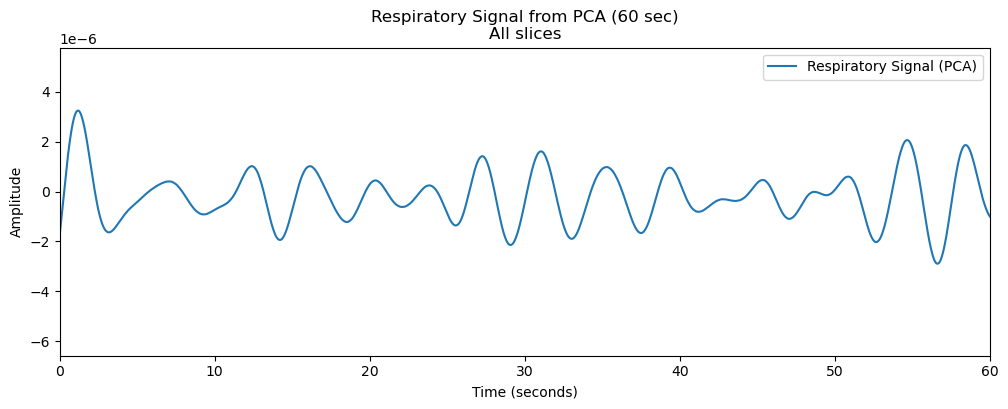

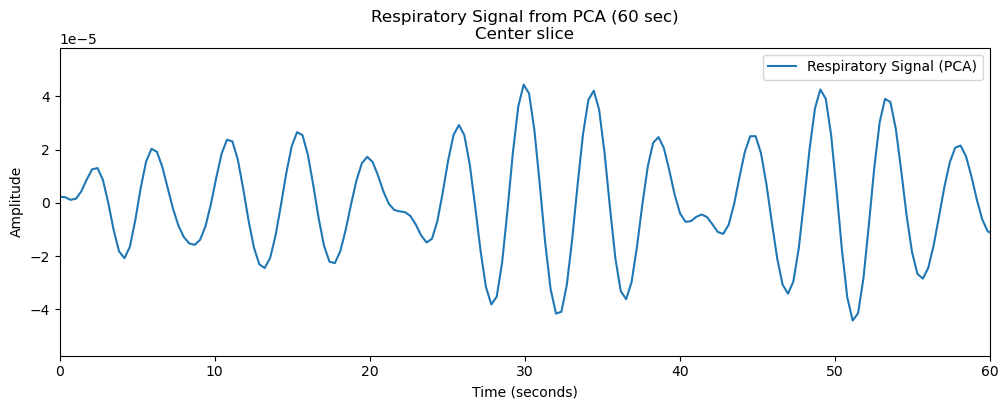

In [11]:
plot_resp_signal(resp_all_slices_pca[3000:], TR=TR, title_info="All slices")
plot_resp_signal(resp_single_slice_pca[30:], TR=TR_effective1, title_info="Center slice")

### Gating : use all z-slices

In [12]:
num_gates = 5
img_shape = (ksp_data.shape[1], ksp_data.shape[3], ksp_data.shape[3])

## Amplitude based
idx_amp_all, resp_trimmed_amp_all, data_bins_amp_all, spoke_bins_amp_all, index_bins_amp_all = gating_functions.gate_resp_signal_dense(ksp_data, 
                                                                                               resp_all_slices_pca,
                                                                                               num_gates=num_gates,
                                                                                               img_shape=img_shape,
                                                                                               spokes_to_discard=3000,
                                                                                               gating_method='amplitude')

## Phase based
idx_phase_all, resp_trimmed_phase_all, data_bins_phase_all, spoke_bins_phase_all, index_bins_phase_all = gating_functions.gate_resp_signal_dense(ksp_data, 
                                                                                               resp_all_slices_pca,
                                                                                               num_gates=num_gates,
                                                                                               img_shape=img_shape,
                                                                                               spokes_to_discard=3000,
                                                                                               gating_method='phase')

Gate 1: 22623 spoke groups, 22623 total spokes, , indices = [0 1 2 3 4 5 6 7 8 9] ...
Gate 2: 22623 spoke groups, 22623 total spokes, , indices = [12 13 14 15 16 17 18 19 20 21] ...
Gate 3: 22623 spoke groups, 22623 total spokes, , indices = [32 33 34 35 36 37 38 39 40 41] ...
Gate 4: 22623 spoke groups, 22623 total spokes, , indices = [47 48 49 50 51 52 53 54 55 56] ...
Gate 5: 22624 spoke groups, 22624 total spokes, , indices = [68 69 70 71 72 73 74 75 76 77] ...
Gate 1: kspace shape = (15, 22623, 256), coords shape = (22623, 256, 3)
Gate 2: kspace shape = (15, 22623, 256), coords shape = (22623, 256, 3)
Gate 3: kspace shape = (15, 22623, 256), coords shape = (22623, 256, 3)
Gate 4: kspace shape = (15, 22623, 256), coords shape = (22623, 256, 3)
Gate 5: kspace shape = (15, 22624, 256), coords shape = (22624, 256, 3)
Gate 1: 17871 spoke groups, 17871 total spokes, , indices = [193 194 195 196 197 198 199 200 201 202] ...
Gate 2: 23743 spoke groups, 23743 total spokes, , indices = [338

Average signal across gates = [8.085029661022757e-07, -4.413514882115207e-07, -1.2062584418751063e-06, -3.6902073178005727e-07, 8.068138491655803e-07]


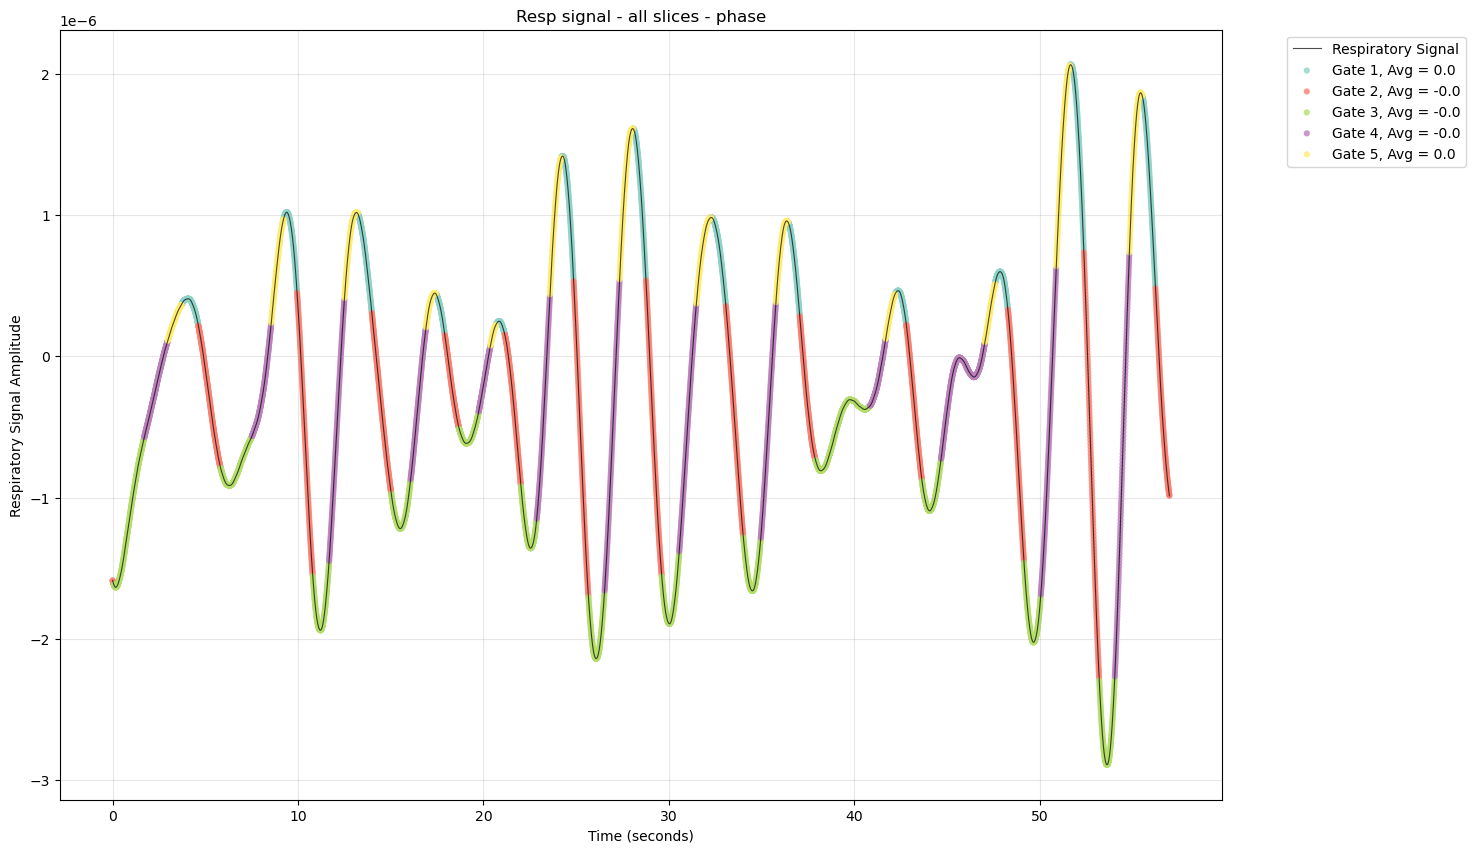

In [15]:
import gating_visuals

gating_visuals.visualize_resp_gating(resp_trimmed_phase_all[500:10000], idx_phase_all[500:10000], 
                                     TR=0.006, num_gates=5, title="Resp signal - all slices - phase")

### Gating : use only center partition

In [ ]:
num_gates = 5
img_shape = (ksp_data.shape[1], ksp_data.shape[3], ksp_data.shape[3])

## Amplitude based 
idx_amp_cent, resp_trimmed_amp_cent, data_bins_amp_cent, spoke_bins_amp_cent, index_bins_amp_cent = gating_functions.gate_resp_signal_sparse(ksp_data, 
                                                                                               resp_single_slice_pca,
                                                                                               num_gates=num_gates,
                                                                                               img_shape=img_shape,
                                                                                               spokes_to_discard=30,
                                                                                               gating_method='amplitude')

## Phase based 
idx_phase_cent, resp_trimmed_phase_cent, data_bins_phase_cent, spoke_bins_phase_cent, index_bins_phase_cent = gating_functions.gate_resp_signal_sparse(ksp_data, 
                                                                                               resp_single_slice_pca,
                                                                                               num_gates=num_gates,
                                                                                               img_shape=img_shape,
                                                                                               spokes_to_discard=30,
                                                                                               gating_method='phase')

In [16]:
def save_gate_outputs_pickle(file, idx, signal_trimmed, data_bins, spoke_bins, index_bins):
    '''Save outputs of gate_resp_signal as compressed npz file
    
    file : file, str, or Pathlib.path
        Either filename (string) or open file (path object) where data should be saved. .npz appended if not already there
    idx : ndarray
        1D array containing gate indices
    signal_trimmed : ndarray
        1D array containing resp signal used for gating
    data_bins : list
        List of ndarrays, each element is gated k-space array
    spoke_bins : list
        List of ndarrays, each element is gated GA coords
    index_bins : list
        List of ndarrays, each element is list of indices for that gate
    
    '''
    data = {
        "idx": idx,
        "signal_trimmed": signal_trimmed,
        "data_bins": data_bins,
        "spoke_bins": spoke_bins,
        "index_bins": index_bins,
    }
    with open(f"{file}.pkl", "wb") as f:
        pickle.dump(data, f)

    print(f'File successfully saved as {file}')

In [17]:
save_gate_outputs_pickle('gates_phase_all_slices_UPDATED', idx_phase_all, resp_trimmed_phase_all, data_bins_phase_all, spoke_bins_phase_all, index_bins_phase_all)

File successfully saved as gates_phase_all_slices_UPDATED


In [ ]:
# save_gate_outputs_pickle('gates_amp_cent_slice', idx_amp_cent, resp_trimmed_amp_cent, data_bins_amp_cent, spoke_bins_amp_cent, index_bins_amp_cent)
# save_gate_outputs_pickle('gates_phase_cent_slice', idx_phase_cent, resp_trimmed_phase_cent, data_bins_phase_cent, spoke_bins_phase_cent, index_bins_phase_cent)

### Save pickle files

In [ ]:
def write_pickle(var, filename):
    '''Write variable to pickle file with given filename'''
    with open(f'{filename}', 'wb') as f:
        pickle.dump(var, f)
        print(f'Successfully saved as {filename}')

def read_pickle(filename):
    '''Read variable from pickle file with given filename'''
    with open(f'{filename}', 'rb') as f:
        var = pickle.load(f)
        return var

##